<a href="https://colab.research.google.com/github/yojashri/image-caption-generator/blob/main/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

adityajn105_flickr8k_path = kagglehub.dataset_download('adityajn105/flickr8k')
yojashrik_vgg16_weights_path = kagglehub.dataset_download('yojashrik/vgg16-weights')
yojashrik_images_path = kagglehub.dataset_download('yojashrik/images')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/images/97577988_65e2eae14a.jpg
/kaggle/input/images/890734502_a5ae67beac.jpg
/kaggle/input/images/2759860913_f75b39d783.jpg
/kaggle/input/images/text.png
/kaggle/input/images/blank.jpeg
/kaggle/input/images/blur
/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/inpu

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2025-06-04 00:26:54.621611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748996814.934237      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748996815.020177      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

# Step 1: Load VGG16 without the top layers
model = VGG16(include_top=False, weights=None)

# Step 2: Load the weights that exclude the top layers
weights_path = '/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
model.load_weights(weights_path)

# Step 3 (Optional): Restructure if needed
model = Model(inputs=model.inputs, outputs=model.output)
print(model.summary())


2025-06-04 00:27:13.813298: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
import os
import numpy as np

# Load VGG16 without top and with local weights
weights_path = '/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights(weights_path)

# Build a new model that flattens and outputs 4096-dim features
x = base_model.output                    # shape: (7, 7, 512)
x = Flatten()(x)                         # shape: (25088,)
x = Dense(4096, activation='relu')(x)    # shape: (4096,)
feature_model = Model(inputs=base_model.input, outputs=x)

# Extract features
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    feature = feature_model.predict(image, verbose=0)  # shape: (1, 4096)
    image_id = img_name.split('.')[0]
    features[image_id] = feature


2025-06-04 03:44:34.477290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749008674.651244      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749008674.704986      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-04 03:44:48.098827: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


NameError: name 'BASE_DIR' is not defined

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 602503.13it/s]


In [ ]:
len(mapping)

8091

In [ ]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = re.sub(r'[^A-Za-z]', ' ', caption)
            caption = re.sub(r'\s+', ' ', caption)
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption


In [ ]:
# preprocess the text
clean(mapping)
for k in list(mapping)[:3]:
    print(k)



1000268201_693b08cb0e
1001773457_577c3a7d70
1002674143_1b742ab4b8


In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)


In [ ]:
len(all_captions)

40455

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8427

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]


In [ ]:

import os;
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

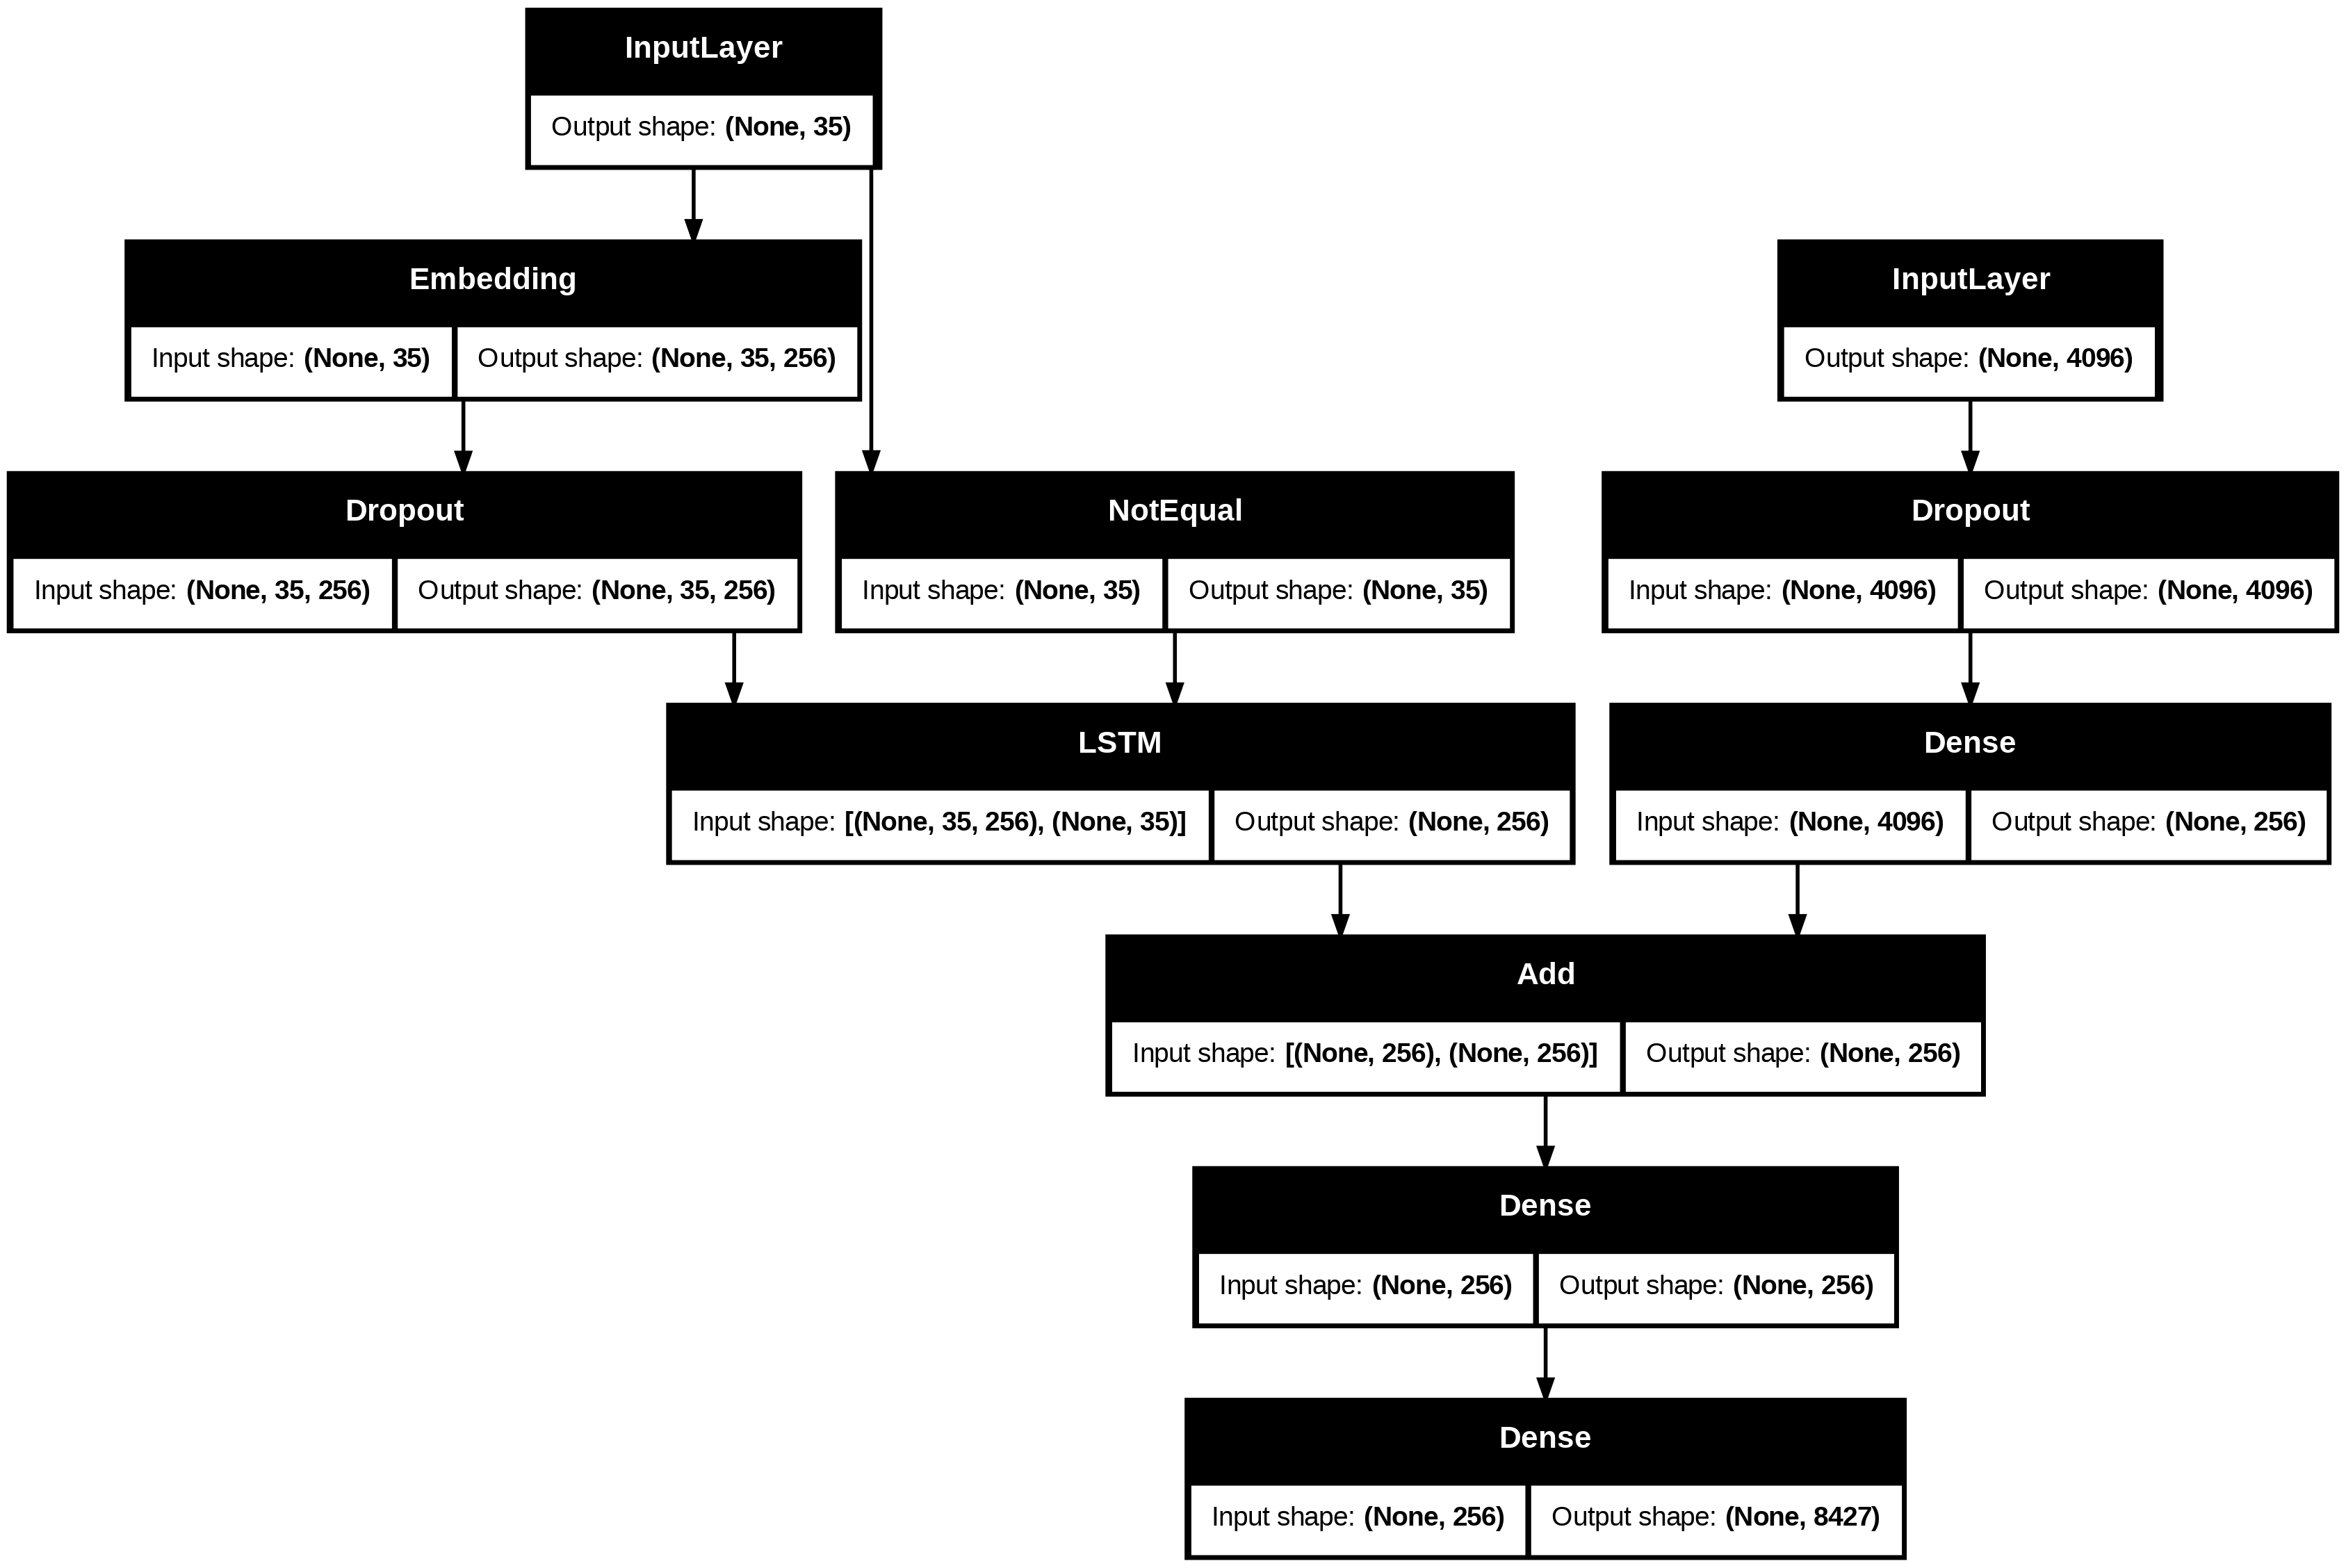

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 2
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_e
              poch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 612s 3s/step - loss: 6.0971
227/227 ━━━━━━━━━━━━━━━━━━━━ 600s 3s/step - loss: 4.4005


In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
import cv2
import numpy as np

def is_blurry(image_path, threshold=100.0):
    image = cv2.imread(image_path)
    if image is None:
        return True  # consider non-loadable image as blurry
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return lap_var < threshold

In [ ]:
def is_blank(image_path, threshold=5.0):
    """Returns True if image is mostly blank (little variation in pixel values)."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return True  # unreadable
    stddev = np.std(image)
    return stddev < threshold  # very low variation → likely blank


In [ ]:
def is_text_only_image(image_path, edge_threshold=1500):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return True

    edges = cv2.Canny(image, 100, 200)
    edge_count = np.sum(edges > 0)

    # Heuristic: if there are many edges (text edges) but little pixel variance, it's likely text-only
    if edge_count > edge_threshold and np.std(image) < 40:
        return True
    return False


In [ ]:
from os.path import basename
import matplotlib.pyplot as plt
from PIL import Image

def generate_caption(image_path):
    try:
        # Load image first
        image = Image.open(image_path).convert("RGB")

        # Show the image regardless of whether it is blank, blurry, etc.
        plt.imshow(image)
        plt.title("Inputa Image")
        plt.axis("off")
        plt.show()

        # Now perform validation checks
        if is_blank(image_path):
            print("blank image cannot be processed")
            return
        if is_blurry(image_path):
            print(" Blurred image cannot be processed.")
            return


        if is_text_only_image(image_path):
            print("Detected text-only image. Please provide a proper image.")
            return

        # If all checks pass, show predicted caption or fallback
        image_id = basename(image_path).split('.')[0]
        print('---------------------Predicted Captions---------------------')
        if image_id in mapping:
            for caption in mapping[image_id]:
                print(caption)
        else:
            print(f" captions not found for image : {image_id}")

    except Exception as e:
        print(" Unable to process image:", e)


In [ ]:
print(list(mapping.keys())[:10])


['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615', '1007320043_627395c3d8', '1009434119_febe49276a', '1012212859_01547e3f17', '1015118661_980735411b', '1015584366_dfcec3c85a']


In [ ]:
print(image_id in mapping)  # should be True
print(image_id)             # check the extracted key


True
997722733_0cb5439472


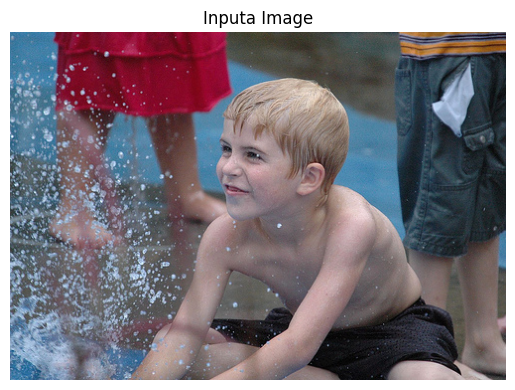

---------------------Predicted Captions---------------------
startseq boy in black swimsuit playing near the water endseq
startseq boy is splashing water in his bathing suit endseq
startseq little shirtless boy in shorts splashes water endseq
startseq boy in black swim trunks playing in spray of water endseq
startseq young boy splashes water at the edge of pool endseq


In [ ]:
generate_caption("/kaggle/input/images/890734502_a5ae67beac.jpg");


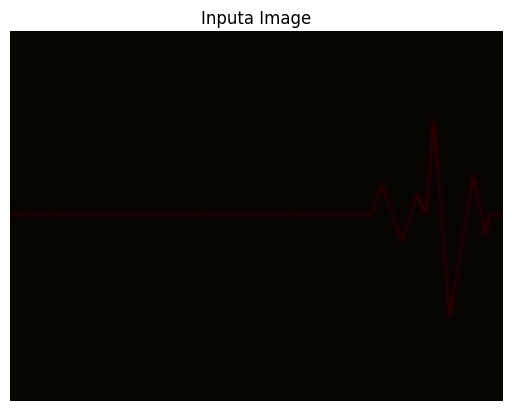

blank image cannot be processed


In [ ]:
generate_caption("/kaggle/input/images/blank.jpeg")

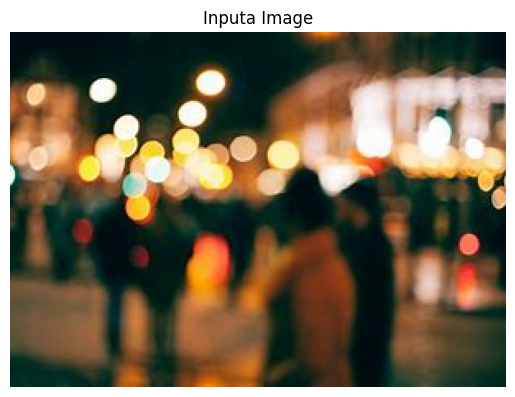

---------------------Predicted Captions---------------------
 captions not found for image : blur


In [ ]:
generate_caption("/kaggle/input/images/blur")

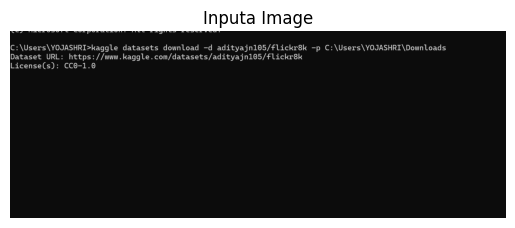

Detected text-only image. Please provide a proper image.


In [ ]:
generate_caption("/kaggle/input/images/text.png")

---------------------Actual---------------------
startseq little kid splashes around in the kiddie pool while lady watches endseq
startseq woman dumping water on small child who is in pool endseq
startseq woman is throwing bucket of water over baby in the paddling pool endseq
startseq woman is throwing water on child in plastic swimming pool in rural area endseq
startseq child slides into wading pool full of water while an adult tosses bucket of water on them endseq


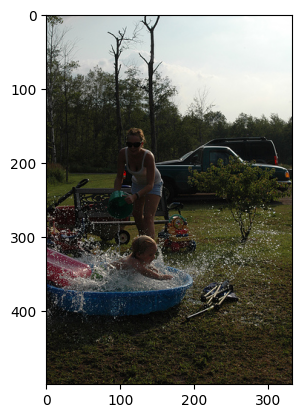

In [ ]:
generate_caption("973827791_467d83986e.jpg")
